<a href="https://colab.research.google.com/drive/14rhux5d5rslpVXFhwan2ogBemJ5SvXr1?authuser=2" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Neural Network (DNN)



## 1. Load dataset

In [1]:
!gdown --folder https://drive.google.com/drive/folders/12_pMH77NyqSnp8NY0EFzZn1dODgrx_p8?usp=drive_link
!unzip dataset/data_500.zip -d ./data500

Retrieving folder contents
Processing file 1T6zw4ggFfFlPQChqWia-VLKct1DTSLK6 data_500.zip
Processing file 1kHHoZPyk0_lCJYwqqaxd0hmBAdAxqEQY data_1000.zip
Processing file 12M-FQcVzzumCnhmFrzPkzeBoBZQtBSbj data_2000.zip
Processing file 1pNYu7bAEp8Lw08-VXMmHAgmEnJNhuhAF data_3000.zip
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1T6zw4ggFfFlPQChqWia-VLKct1DTSLK6
To: /content/dataset/data_500.zip
100% 567k/567k [00:00<00:00, 33.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1kHHoZPyk0_lCJYwqqaxd0hmBAdAxqEQY
To: /content/dataset/data_1000.zip
100% 1.20M/1.20M [00:00<00:00, 41.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=12M-FQcVzzumCnhmFrzPkzeBoBZQtBSbj
To: /content/dataset/data_2000.zip
100% 2.27M/2.27M [00:00<00:00, 205MB/s]
Downloading...
From: https://drive.google.com/uc?id=1pNYu7bAEp8Lw08-VXMmHAgmEnJNhuhAF
To: /content/dataset/data_3000.zip
100% 3.31M

## 2. Import python libraries and define util functions

In [2]:
# Install library
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.2/869.2 kB 42.6 MB/s eta 0:00:00


In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from mpl_toolkits.axes_grid1 import make_axes_locatable
import random
import os
import glob
import random
from torchmetrics.functional.regression import mean_squared_error  # regression metric: MSE
from torchmetrics.functional.regression import mean_absolute_percentage_error  # regression metric: MAPE

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# function to plot a line graph for RMSE history after model training
def plot_rmse(rmse_train_history, rmse_valid_history, title=None):

    plt.plot(rmse_train_history)
    plt.plot(rmse_valid_history)
    if title is not None:
        plt.title(title)
    plt.ylabel('RMSE')
    plt.xlabel('Epochs')
    plt.legend(['Training data', 'Validation data'], loc=0)
    # plt.show()

# function to plot a line graph for MAPE history after model training
def plot_mape(mape_train_history, mape_valid_history, title=None):

    plt.plot(mape_train_history)
    plt.plot(mape_valid_history)
    if title is not None:
        plt.title(title)
    plt.ylabel('MAPE')
    plt.xlabel('Epochs')
    plt.legend(['Training data', 'Validation data'], loc=0)
    # plt.show()

# function to plot a line graph for loss history after model training
def plot_loss(loss_train_history, loss_valid_history, title=None):

    plt.plot(loss_train_history)
    plt.plot(loss_valid_history)
    if title is not None:
        plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(['Training data', 'Validation data'], loc=0)
    # plt.show()

def set_seed(seed=42):
    # Fix random seed
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

    # CuDNN setup
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def draw_img_from_cond(path, cmap='gray'):
    plt.figure(figsize=(3,3))
    img = np.load(path)
    plt.imshow(img, cmap=cmap)
    plt.colorbar()
    plt.show()
    return img


def draw_dist(inputs, samples=100):
    if len(inputs) > samples:
        inputs = random.sample(list(inputs), samples)

    pixel_values = []
    for item in inputs:
        if isinstance(item, Image.Image):
            pixel_values.extend(list(item.getdata()))
        elif isinstance(item, np.ndarray):
            pixel_values.extend(item.flatten())
        elif torch.is_tensor(item):
            if len(item.shape) == 4 and item.shape[1] == 1:  #Image shape: (batch_size, 1, height, width)
                item = item.squeeze(1)
            elif len(item.shape) == 3:  #Image shape: (batch_size, height, width)
                item = item.unsqueeze(1)
            else:
                raise ValueError("Unsupported image shape. Supported shapes: (batch_size, height, width) or (batch_size, 1, height, width).")
            item = item.detach().cpu().numpy()
            pixel_values.extend(item.flatten())
        else:
            raise ValueError("Unsupported image type. Supported types: PIL Image, numpy array, torch tensor.")

    plt.figure(figsize=(5,3))
    plt.hist(pixel_values, bins=20, color='blue', alpha=0.7)
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    plt.title('Image Pixel Value Distribution')
    plt.show()



def show_img(images_list,
             r=1,
             cmap='gray',
             img_size=(5, 5),
             axis="off",
             colorbar=False,
             colorbar_range=None,
             save_path=None):
    if r < 1:
        r = 1

    total_images = len(images_list)
    if total_images == 0:
        print("No images to display.")
        return

    cols = (total_images + r - 1) // r
    fig, axs = plt.subplots(r, cols, figsize=(cols * img_size[0], r * img_size[1]))

    if r == 1:
        axs = axs.reshape(1, -1)

    for idx, item in enumerate(images_list):
        ax = axs[0, idx] if r == 1 else axs[idx // cols, idx % cols]
        im = None
        if isinstance(item, Image.Image):
            if item.mode in ['L', '1']:  # Grayscale images
                im = ax.imshow(item, cmap=cmap)
            else:  # Color images
                im = ax.imshow(item)
        elif isinstance(item, np.ndarray):
            if item.ndim == 2:  # 2D array, grayscale image
                im = ax.imshow(item, cmap=cmap, vmin=colorbar_range[0] if colorbar_range else None, vmax=colorbar_range[1] if colorbar_range else None)
            elif item.ndim == 3:  # 3D array, color image
                im = ax.imshow(item, cmap=cmap if item.shape[-1] == 1 else None, vmin=colorbar_range[0] if colorbar_range else None, vmax=colorbar_range[1] if colorbar_range else None)
            elif item.ndim == 4 and item.shape[0] == 1:  # 4D array with batch dimension of 1
                im = ax.imshow(item[0], cmap=cmap if item.shape[1] == 1 else None, vmin=colorbar_range[0] if colorbar_range else None, vmax=colorbar_range[1] if colorbar_range else None)
            else:
                raise ValueError(f"Unsupported numpy array shape: {item.shape}.")
        elif torch.is_tensor(item):
            item = item.detach().cpu().numpy()
            if item.ndim == 2:  # 2D tensor, grayscale image
                im = ax.imshow(item, cmap=cmap, vmin=colorbar_range[0] if colorbar_range else None, vmax=colorbar_range[1] if colorbar_range else None)
            elif item.ndim == 3:  # 3D tensor, color image
                im = ax.imshow(item.transpose(1, 2, 0), cmap=cmap if item.shape[0] == 1 else None, vmin=colorbar_range[0] if colorbar_range else None, vmax=colorbar_range[1] if colorbar_range else None)
            elif item.ndim == 4 and item.shape[0] == 1:  # 4D tensor with batch dimension of 1
                im = ax.imshow(item[0].transpose(1, 2, 0), cmap=cmap if item.shape[1] == 1 else None, vmin=colorbar_range[0] if colorbar_range else None, vmax=colorbar_range[1] if colorbar_range else None)
            else:
                raise ValueError(f"Unsupported torch tensor shape: {item.shape}.")
        else:
            raise ValueError("Unsupported image type. Supported types: PIL Image, numpy array, torch tensor.")

        if colorbar and im is not None:
            divider = make_axes_locatable(ax)
            cax = divider.append_axes("right", size="5%", pad=0.05)
            fig.colorbar(im, cax=cax)

        ax.axis(axis)

    plt.tight_layout()
    # Save image
    if save_path is not None:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, bbox_inches='tight')
        plt.close()
    else:
        plt.show()

In [4]:
set_seed(0)

## 3. Dataset check

In [5]:
path = './data500/26.831.jpg'
from PIL import Image
img = Image.open(path)
img.show()
img_array = np.array(img)
print(img_array.shape)

(56, 56)


## 4. Define dataloader

In [6]:
import torch
import numpy as np
import glob
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms


class PP(Dataset):

    def __init__(self,
                 paths=[],
                 resize=None,
                 batch_size: int = 4,
                 shuffle: bool = True,
                 dtype = torch.float32,
                ):

        # init
        self.paths = paths

        self.resize = resize
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.dtype = dtype

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):

        path = self.paths[idx]
        img = Image.open(path)
        x = np.array(img)/255
        x = torch.tensor(x, dtype=self.dtype).unsqueeze(0).flatten()
        y = torch.tensor(float(os.path.splitext(path.split('/')[-1])[0]), dtype=self.dtype)
        return x, y

    def get_loader(self):
        return DataLoader(self, batch_size=self.batch_size, shuffle=self.shuffle)

    def get_batch(self, idx=0):
        ds = self.get_loader()
        for i, batch in enumerate(ds):
            if i == idx:
                break
        return batch

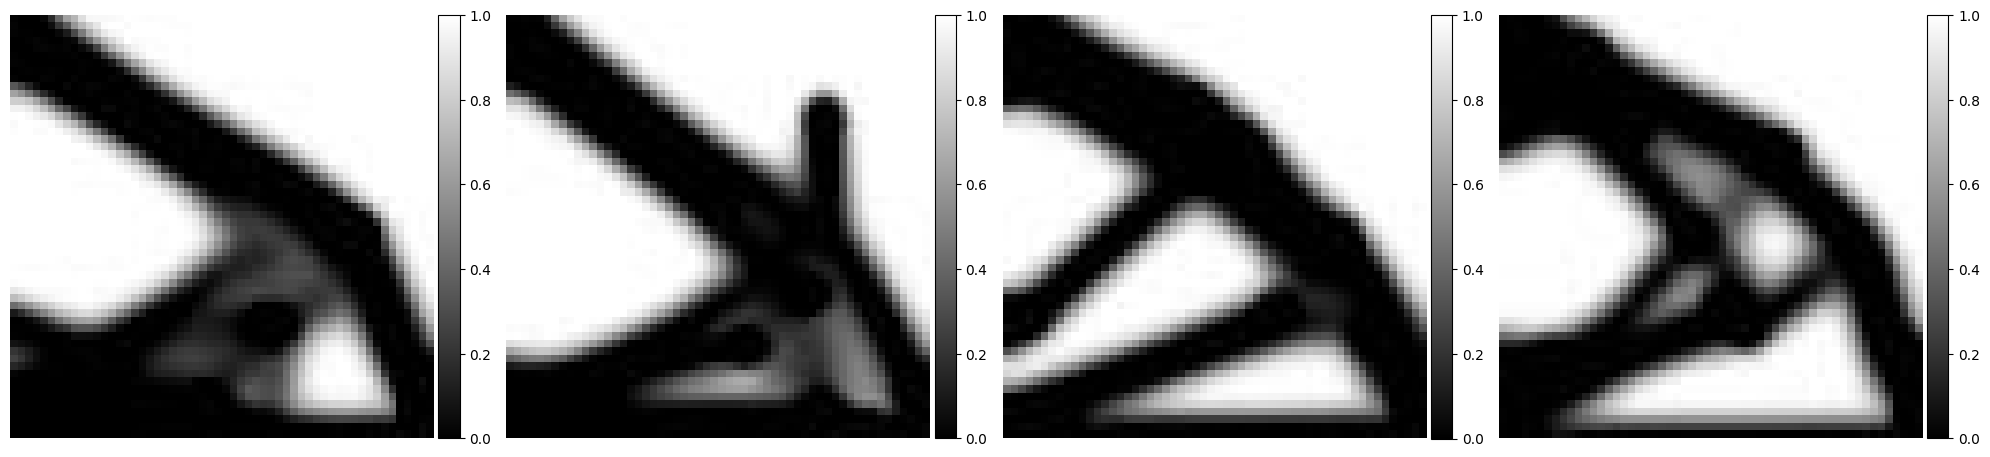

In [7]:

paths= glob.glob('data500/*jpg')
random.shuffle(paths)
idx = int(len(paths) * 0.8)

train_pipe = PP(paths[:idx])# resize=128)
test_pipe = PP(paths[idx:])#, resize=128)
images,y  = train_pipe.get_batch(0)
show_img(images.reshape(4,1,56,56), colorbar=True)

## 5. Define model and train

### **| DNN**


In [8]:
# DNN Model
class DNN(nn.Module):
    def __init__(self):
        super(DNN, self).__init__()
        self.fc1 = nn.Linear(56*56, 512)  # Input layer (Convert 56x56 image into flatten vector)
        self.fc2 = nn.Linear(512, 256)    # Hidder layer 1
        self.fc3 = nn.Linear(256, 128)    # Hidden layer 2
        self.fc4 = nn.Linear(128, 1)     # Output layer

    def forward(self, x):
        x = F.relu(self.fc1(x))  # 1st layer with activation function ReLU
        x = F.relu(self.fc2(x))  # 2nd layer with activation function ReLU
        x = F.relu(self.fc3(x))  # 3rd layer with activation function ReLU
        x = self.fc4(x)          # Output layer
        return x

In [21]:
def train(model, train_loader, optimizer, criterion, epoch, device):
    model.train()
    model.to(device)
    total_loss = 0
    total_num = 0
    rmse_train = 0
    mape_train = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device)
        target = target.to(device).squeeze()
        optimizer.zero_grad()  # Gradient initialize
        output = model(data).squeeze()   # Train the model model
        loss = criterion(output, target)  # Calculate loss
        loss.backward()        # Back-propagate
        optimizer.step()       # Update model weights
        total_loss += loss.item()
        rmse_train += mean_squared_error(output, target, squared=False).item() # returns RMSE value if set to False
        mape_train += mean_absolute_percentage_error(output, target).item() * 100
    total_num = len(train_loader)

    avg_loss = total_loss / total_num
    average_rmse_train = rmse_train / total_num
    average_mape_train = mape_train / total_num

#    print(f'Epoch {epoch}, Training Loss: {avg_loss:.4f}')
    return avg_loss, average_rmse_train, average_mape_train

# 5. Test loop
def test(model, test_loader, criterion, device):
    model.eval()
    model.to(device)
    total_loss = 0
    total_num = 0
    rmse_test = 0
    mape_test = 0
    with torch.no_grad():  # Do not calculate gradient on the inference step
        for data, target in test_loader:
            data = data.to(device)
            target = target.to(device).squeeze()
            output = model(data).squeeze()
            loss = criterion(output, target)
            total_loss += loss.item()
            rmse_test += mean_squared_error(output, target, squared=False).item() # returns RMSE value if set to False
            mape_test += mean_absolute_percentage_error(output, target).item() * 100
    total_num = len(test_loader)
    avg_loss = total_loss / total_num
    average_rmse = rmse_test / total_num
    average_mape = mape_test / total_num
#    print(f'Test Loss: {avg_loss:.4f}')
    return avg_loss, average_rmse, average_mape


In [26]:
# 6. Implement train & test
# 3. Model, Loss function and optimizer set up
criterion = nn.MSELoss()  # Loss function: MSE
lr = 0.00005
train_epochs = 100

model = DNN()

optimizer = optim.Adam(model.parameters(), lr=lr)  # Optimizer: Adam
train_loader = train_pipe.get_loader()
test_loader = test_pipe.get_loader()

loss_train_history = []
rmse_train_history = []
mape_train_history = []

loss_valid_history = []
rmse_valid_history = []
mape_valid_history = []

for epoch in range(train_epochs):
    avg_loss, average_rmse_train, average_mape_train = train(model, train_loader, optimizer, criterion, epoch, device)
    avg_test_loss, average_rmse_test, average_mape_test  = test(model, test_loader, criterion, device)

    loss_train_history.append(avg_loss)
    rmse_train_history.append(average_rmse_train)
    mape_train_history.append(average_mape_train)

    loss_valid_history.append(avg_test_loss)
    rmse_valid_history.append(average_rmse_test)
    mape_valid_history.append(average_mape_test)

    print(f"Epoch [{epoch+1}/{train_epochs}], TRAIN_RMSE: {average_rmse_train:.4f}, TRAIN_MAPE: {average_mape_train:.4f}, VAL_RMSE: {average_rmse_test:.4f}, VAL_MAPE: {average_mape_test:.4f}")

Epoch [1/100], TRAIN_RMSE: 15.4416, TRAIN_MAPE: 56.7127, VAL_RMSE: 1.6390, VAL_MAPE: 5.4646
Epoch [2/100], TRAIN_RMSE: 1.5426, TRAIN_MAPE: 5.0385, VAL_RMSE: 1.4542, VAL_MAPE: 4.6652
Epoch [3/100], TRAIN_RMSE: 1.4069, TRAIN_MAPE: 4.6185, VAL_RMSE: 1.3175, VAL_MAPE: 4.3452
Epoch [4/100], TRAIN_RMSE: 1.3033, TRAIN_MAPE: 4.2402, VAL_RMSE: 1.2449, VAL_MAPE: 4.0764
Epoch [5/100], TRAIN_RMSE: 1.2253, TRAIN_MAPE: 3.9770, VAL_RMSE: 1.1704, VAL_MAPE: 3.8114
Epoch [6/100], TRAIN_RMSE: 1.1503, TRAIN_MAPE: 3.6926, VAL_RMSE: 1.1093, VAL_MAPE: 3.5808
Epoch [7/100], TRAIN_RMSE: 1.0885, TRAIN_MAPE: 3.5389, VAL_RMSE: 1.0439, VAL_MAPE: 3.4030
Epoch [8/100], TRAIN_RMSE: 1.0182, TRAIN_MAPE: 3.3280, VAL_RMSE: 1.0106, VAL_MAPE: 3.2185
Epoch [9/100], TRAIN_RMSE: 0.9869, TRAIN_MAPE: 3.1979, VAL_RMSE: 0.9256, VAL_MAPE: 3.0245
Epoch [10/100], TRAIN_RMSE: 0.9341, TRAIN_MAPE: 3.0415, VAL_RMSE: 0.9333, VAL_MAPE: 2.9277
Epoch [11/100], TRAIN_RMSE: 0.9286, TRAIN_MAPE: 2.9431, VAL_RMSE: 0.8630, VAL_MAPE: 2.7854
Epoch 

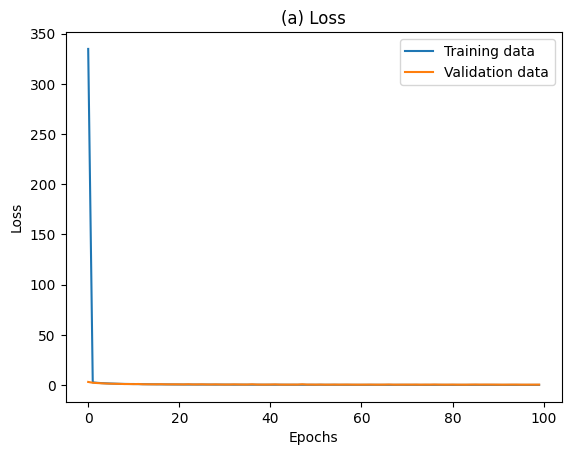

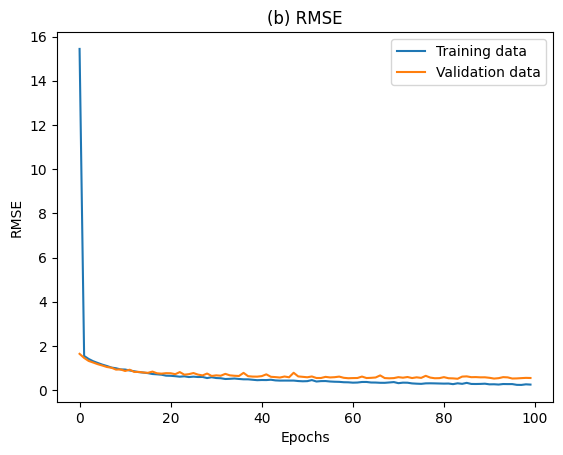

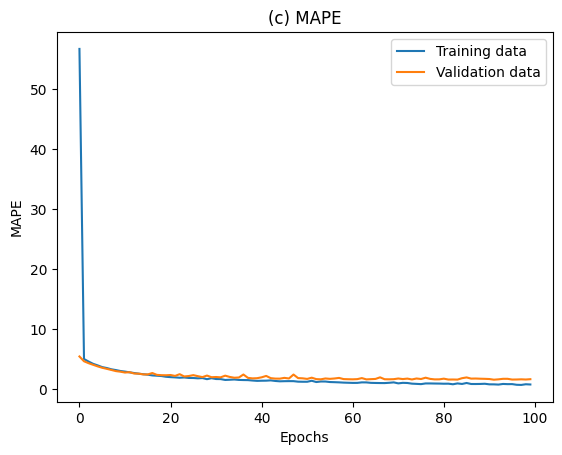

In [28]:
# Graph Visualization
plot_loss(loss_train_history, loss_valid_history, '(a) Loss')  # Loss variation over epochs during training
plt.show()
plot_rmse(rmse_train_history, rmse_valid_history, '(b) RMSE')  # RMSE variation over epochs during training
plt.show()
plot_mape(mape_train_history, mape_valid_history, '(c) MAPE')  # MAPE variation over epochs during training
plt.show()